# Lyfe - Une certaine définition du vivant

Projet informatique mené par Vassili DESAGES & Till PERSON, L3 Sciences de la Matière, dans le cadre de l'UE "Projet numérique" pendant l'année scolaire 2021-2022. Ce rapport est rédigé sur Jupyter Notebook et donc interactif, n'oubliez pas d'éxécuter les cellules dans l'ordre afin d'afficher correctement les résultats. Veillez aussi à bien avoir enregistrer le fichier $\texttt{param.txt}$ dans le même répertoire que ce fichier Jupyter Notebook.

# Définition du problème

## Introduction

Nous cherchons dans ce projet à reproduire l'émergence et le comportement de structures bien connues, présentes dans la nature : les motifs de Turing. Ces motifs nous sont familiers, on les retrouve par exemple sur le poisson globe-géant, la fourrure d'un léopard ou encore sur certains coquillages. L'origine de ces motifs très réguliers n'est pas encore parfaitement comprise car elle repose sur des mécanismes biologiques complexes : la morphogénèse, la différenciation, etc. Néanmoins, le mathématician Alan Turing proposa en 1952 dans son essai ["The Chemical Basis of Morphogenesis"](https://link.springer.com/content/pdf/10.1007/BF02459572.pdf) une première explication. Il suggère une modélisation thermochimique simple à ce phénomène. Sous ce prisme, il démontre que les motifs de Turing émergent naturellement comme solution des équations de réaction-diffusion. Nous allons tenter de résoudre ces équations pour visualiser ces motifs.

<img src="globe.png"  width="1000" />

    


## Modélisation Théorique Succinte

En réalité, les équations de réaction-diffusion sont une grande classe d'équations aux dérivées partielles, qui ne possède souvent pas de solution anaytique. On retrouve parmi elle le système d'équation de Gray-Scott dont nous rappelons la construction : considérons deux espèces chimiques V et U (et une troisième espèce P qui est un déchet de réaction). Les équations qui régissent leurs évolutions sont les suivantes :

<br>
$\begin{align}
U + 2V & \rightarrow 3V \\
V & \rightarrow P \\
\end{align}$ 
<br>
<br>
De ces équations nous déduisons l'évolution dans le temps et dans l'espace des espèces U et V, ce sont les équations de Gray-Scott.
<br>
<br>
$\begin{align}
\frac{\partial U}{\partial t} & = D_{u}\Delta U - UV^{2} + F(1-U)\\
\frac{\partial V}{\partial t} & = D_{v}\Delta V + UV^{2} - (F+k)V\\
\end{align}$
<br><br>
Sans rentrer dans la construction de ces équations, nous pouvons identifier 2 phénomènes couplés dans ces équations. D'une part les phénomènes de diffusion thermique reconnaissable par la présence de l'opérateur Laplacien $\Delta$ et des coefficients de diffusion $D_{u}$ et $D_{v}$. D'autre part des phénomènes de cinétique chimique caractérisés par le coefficients d'annihilation $k$ et de création $F$.

## Objectif du projet

Ces équations, de part leurs structures, n'ont pas de solution analytique. L'emploi d'une résolution numérique semble alors justifiée. Le chercheur John E. Pearson, du laboratoire national de Los Alamos, propose dans un article [un article](https://www.ljll.math.upmc.fr/hecht/ftp/ff++/2015-cimpa-IIT/edp-tuto/Pearson.pdf) qui fait désormais référence, des résolutions de ces équations pour différents paramètres $F$ et $k$. Il dresse notamment un "diagramme de phase" qui répertorie les motifs régulier émergent en fonction de ces paramètres. Concrètement, notre objectif sera d'obtenir les mêmes résultats. Nous chercherons dans un second temps à analyser tous ces motifs pour essayer de mettre en évidence des comportements caractéristiques. En d'autres termes, notre rapport se concentrera dans un premier temps sur l'implémentation de la résolution numérique et dans un second temps de l'analyse physique de nos simulations.

# Exécution du projet

## Outils utilisés

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PyQt5 import QtWidgets
import time
import datetime
import os
import scipy.optimize as opt
import sys

Notre projet se prête très bien à une résolution par une approche procédurale. Notre code appelera à tour de rôle les fonctions qui lui permettront de calculer et d'afficher les résultats souhaités. Nous utilisons l'arsenal usuel de librairies python:
- Numpy et scipy.optimize pour les calculs :
- Matplotlib et PyQt5 pour l'affichage et l'animation
- Time, datetime, os et sys pour l'organisation des données récoltées

Explicitions désormais les différentes fonctions que nous utilisons.

### La fonction opérateur laplacien $\Delta$

In [21]:
def lap(M, dx, dy):
    """Permet d'obtenir le laplacien discret de la matrice M"""
    L = - (2*M)/(dx**2) - (2*M)/(dy**2)
    L += (np.roll(M, (0,-1), (0,1)))/(dx**2) # voisin de droite
    L += (np.roll(M, (0,+1), (0,1)))/(dx**2) # voisin de gauche
    L += (np.roll(M, (-1,0), (0,1)))/(dy**2) # voisin du dessus
    L += (np.roll(M, (+1,0), (0,1)))/(dy**2) # voisin du dessous
    return L


Le Laplacien est un opérateur différentiel d'ordre 2. Nous avons l'avons implementé à partir de sa définition par la méthode des différences finies. La fonction va dans un premier temps retrancher dans les deux directions par la résolution spatiale. A chaque appel, le laplacien sera calculé en repoussant les bords de la matrice grâce aux fonctions $\texttt{np.roll}$. On considère ainsi que nos conditions aux limites sont périodiques.

### Les équations de Gray-Scott

In [22]:
def G_S(u, v, f, k, Du, Dv, dx, dy):
    """Renvoie les valeurs des dérivées temporelles des concentrations en U et V selon le modèle de réaction-diffusion de Gray-Scott"""
    """u et v sont des matrices contenant les concentrations en U et V (en mol.L⁻¹), f est le "feed-rate"(en s⁻¹), k (en s⁻¹) est le taux de conversion de U (en P, inerte), et Du (resp. Dv) est le coefficient de diffusion de U (resp. V) (en m².s⁻¹)."""
    u_dot = Du * lap(u, dx, dy) - u * v**2 + f * (1-u)
    v_dot = Dv * lap(v, dx, dy) + u * v**2 - (f + k) * v
    return (u_dot, v_dot)


Il s'agit de la fonction centrale de notre programme puisqu'elle implémente les équations de Gray-Scott présentées en première partie de ce rapport. Il ne s'agit de rien d'autre que des expressions mathématiques de ces dernières. Cette fonction sera ensuite appelée dans un schéma de résolution de type méthode d'Euler. Nous reviendrons plus tard sur cette méthode de résolution.

### Fonction de régréssion polynomiale

In [23]:
def courbe_fit(t,A,B, C):
    return A*t**0.5 + B*t + C

Il s'agit d'une fonction à paramètres variables pour permettre un fit via $\texttt{scipy.optimize}$.

### Introduction des variables

In [24]:
try:
    param=np.loadtxt("param.txt",delimiter=";", skiprows=2, usecols=1)
except IOError:
    print('ERREUR : le fichier param.txt ne se trouve pas dans l\'emplacement de travail, veuillez le déplacer vers : ' + adresse + ' ou changer de répertoire de travail.')
    sys.exit()

Afin de s'inscrire complètement dans la démarche du physicien numéricien, il est important de rendre l'exploitation de notre code la plus autonome possible. Nous devions faire en sorte que notre programme puisse fonctionner sans avoir à ouvrir le code dans un éditeur. Autrement dit, nous devions pouvoir récupérer les données uniquement en éxécutant le code et en insérant un fichier de données externe. Les lignes de codes précédentes remplissent ce rôle. De cette façon, il nous suffit de modifier les paramètres d'entrées dans le fichier $\texttt{param.txt}$

In [25]:
adresse = os.getcwd() #emplacement du dossier de travail
d = str(datetime.datetime.today())
#chaîne de caractères contenant la date et l'heure à la seconde près
date_heure = d[:10]+'_'+ d[-15:-13] + '-' +d[-12:-10]+'-'+d[-9:-7] 
dt = param[0]
duree = param[1]
Npas = int(duree / dt)
Nx = int(param[2])
Ny = int(param[3])
dx = param[4]
dy = param[5]
Lx = dx * Nx
Ly = dy * Ny
F = param[6]
k = param[7]
Ds = param[8]
Dg = param[9]
d = int(param[10])
loc, scale = param[11], param[12]
N_save = int(param[13])
N_calc_mean = int(param[14])
save_ok = int(param[15])
tracking_ok = param[16]
circle_ok = param[17]
diag_ok = param[18]
diag_save_ok = param[19]
disp_ok = param[20]

### Initialisation

In [26]:
# On initialise le canevas:
    
xx = np.linspace(0, Lx, Nx)
yy = np.linspace(0, Ly, Ny)
    
# On initialise deux tableaux qui porteront chacun les valeurs, en tout point, des concentrations en U et en V
    
conc_S = np.ones((Nx, Ny))
conc_G = np.zeros((Nx, Ny))
    
# On perturbe cet etat de départ, en changeant la concentration en V d'un carré au centre, de cote 2d, que l'on perturbe lui-même avec un bruit blanc gaussien
    
conc_S[Nx//2 - d: Nx //2 + d, Ny//2 - d: Ny //2 + d] = 0.50
conc_G[Nx//2 - d: Nx //2 + d, Ny//2 - d: Ny //2 + d] = 0.25 + np.random.normal(loc, scale, size=(2*d, 2*d))
    
#On calcule le coût en temps des différentes opérations 
    
temps_total = 0 #le temps TOTAL de la simulation
temps_calcul = 0  #le temps TOTAL dédié au calcul 'pur'
temps_generation = 0 #le temps TOTAL de génération et de sauvegarde (si activée) des images
    
#Ces lignes permettront le tracé du cercle englobant la substance G
    
theta = np.linspace(0, np.pi*2, 100)
rayons = []
    
#On ajoute au fichier contenant les images une copie du fichier 'param.txt' utilisé
    
if save_ok == 1:
    nom_dossier_sim = adresse + '/' + 'simulation_'+date_heure
    os.makedirs(nom_dossier_sim) #on crée le dossier de sauvegarde des images
    file = open(nom_dossier_sim + '/' +'parametres_'+date_heure +'.txt', 'w')
    readme = open('param.txt')
    R = readme.readlines()
    for i in range (len(R)):
            file.write(R[i])
    readme.close()
    file.close()
if diag_save_ok == 1:
    nom_dossier_diag = adresse + '/' + 'diagramme_'+date_heure
    os.makedirs(nom_dossier_diag) #on crée le dossier de sauvegarde des images
    file = open(nom_dossier_diag + '/' +'parametres_'+date_heure +'.txt', 'w')
    readme = open('param.txt')
    R = readme.readlines()
    for i in range (len(R)):
        file.write(R[i])
    readme.close()
    file.close()


On génère ici tout les objets qui nous serviront pour nos simulations. Physiquement, $\texttt{cons_S}$ et $\texttt{cons_G}$ correspondent aux espèces chimiques dont on va calculer la répartition dans l'espace au cours du temps. Initialement, on place ces deux espèces au centre de notre aire d'intêret. On choisit ensuite de perturber les valeurs des fractions molaire d'une des deux espèces avec un bruit Gaussien pour briser la symétrie des conditions initiales.

## Evolution et création des données

### Simulation et calcul des rayons, affichage et sauvegarde des images

In [27]:
if diag_ok == 0:
    for n in range(0,Npas):
            
        start = time.time()
            
        conc_S += G_S(conc_S,conc_G, F, k, Ds, Dg, dx, dy)[0] * dt
        conc_G += G_S(conc_S,conc_G, F, k, Ds, Dg, dx, dy)[1] * dt
            
        temps_calcul += time.time() - start
        temps_total += time.time() - start
            
        if n % N_save == 0:
                
            start = time.time()
            if n != 0 :
                print(str(n) +' ième étape\n')
                plt.clf() #ôte la précedente image de la mémoire
    
            if tracking_ok == 1:
                somme = np.sum(conc_G)
                ind = np.argwhere(conc_G > 0.001)
                    
                i_min = np.min(ind[:,0])
                i_max = np.max(ind[:,0])
                j_min = np.min(ind[:,1])
                j_max = np.max(ind[:,1])
                    
                r_j = (j_max - j_min)/2
                r_i = (i_max - i_min)/2
                    
                r = (r_i + r_j)/2
                r = r * dx
                rayons.append(r)
                x1 = r*np.cos(theta) + Lx/2
                x2 = r*np.sin(theta) + Ly/2
                print('Etalement de taille : ' + str(r)[:6] +' m \n' )
                if circle_ok == 1:
                    plt.plot(x1,x2, 'w--')
    
            plt.figure(1, (20, 20))
            plt.pcolormesh(xx,yy,conc_G,shading='gouraud',cmap='inferno',vmin=0,vmax=0.5)
            plt.colorbar(label = 'Fraction molaire de G')
            plt.title("Durée écoulée :  " + str(n*dt)[:5] + ' (en seconde)')
            plt.xlabel('x (en mètres)')
            plt.ylabel('y (en mètres)')
                
            #a décommenter en cas de problème d'affichage
            #plt.draw()
                
            if 'qt' in plt.get_backend().lower():
            # permet l'affichage image par image grâce à PyQt5
                QtWidgets.QApplication.processEvents()
            if save_ok == 1:
            #le format des images sauvegardées peut être changé ici
                if disp_ok == 0:
                    plt.close()
                plt.savefig(nom_dossier_sim + '/image_' + str(n) + '.jpg')
            temps_generation += time.time() - start
            temps_total += time.time() - start
                
        if n % N_calc_mean == 0 and n>0:
            #ceci permet d'actualiser les valeurs moyennes des temps de calcul et de sauvegarde
            print("Temps de calcul moyen de calcul d'une image : " + str(np.format_float_scientific(temps_calcul /n, precision = 2)) + ' (en s)')
            print("Temps moyen de génération d'une image : " + str(np.format_float_scientific(temps_generation /(n/N_save), precision = 2)) + ' (en s)')
            print("Durée totale de la simulation : "+ str(np.format_float_scientific(temps_total/60, precision = 2)) + ' (en min)')
            print('\n')

Cette partie du code est la plus essentielle. C'est ici que sont calculées, représentées et sauvegardées les images des évolutions physiques de nos espèces. On effectue la même suite d'opérations :

- Résolution des équations de Gray-Scott par la méthode d'Euler
- Sauvegarde des images tout les $\texttt{N_disp_save}$ pas de temps
- Traitement des données : choix des traitements laissé à l'utilisateur
- Animation des données et affichage du temps de calcul et du rayon de la tâche centrale entre chaque itération

# Autour de notre programme

## La résolution par la méthode d'Euler

Nous avons fait le choix de la méthode d'Euler, car c'est un schéma de résolution simple à implémenter. Pour autant, en programmation, rien n'est gagné d'avance. Il est arrivé à plusieurs reprises que notre programme cesse de fonctionner au bout de quelques itérations. Il nous a fallu sonder davantages les équations que nous tentions de résoudre pour comprendre d'où venait ce phénomène. Il est important de comprendre que le choix du pas de temps et d'espace est corrélé et qu'il existe un critère de stabilité numérique pour choisir ces grandeurs. Cependant, nos équations étant non linéaires et couplées, déterminer l'expression de ce critère relevait davantages de l'analyse numérique que du coeur de notre projet.<br>
<br>
Notre équation ressemblant fortement à une [équation de la chaleur](http://math.tifrbng.res.in/~praveen/notes/cm2013/heat_1d.pdf), nous avons trouvé judicieux d'utiliser le même critère pour le choix de nos pas de temps $\Delta t$ et d'espace $\Delta x$ pour notre programme :

$\hspace{12cm} \begin{equation}\Delta t \leq \frac{{\Delta x}^{2}}{2 D}\end{equation}$

<br>
$D$ Désigne un des deux coefficients de diffusion introduit plus tôt.

## Bien choisir les paramètres de simulation

Fort de ce critère de stabilité, il faut aussi réfléchir judicieusement au choix des grandeurs caractéristiques. En d'autres termes, il faut choisir des grandeurs d'un ordre de grandeur semblable à celles de matériel de laboratoire, par exemple. L'ordre de grandeur de nos coefficients de diffusion est de $10^{-5}$ $m^{2}.s^{-1}$. Si l'on ne prends en compte que la diffusion pour la propagation de nos espèces : il faut donc considérer une simulation correspondant à dix mille secondes pour qu'elles s'étalent sur une surface équivalente à celle d'une paillasse de laboratoire, de l'ordre du mètre carré. Ce simple raisonnement par ordre de grandeur nous a permis de paramétrer avec cohérence notre simulation. Il était alors évident de trouver le pas de temps $\Delta t$ et d'espace $\Delta x$ en considérent des déplacements de l'ordre du centimètre et de la seconde.
<br>
Nous pouvons aussi discuter du dernier paramètre clé pour la simulation : la résolution. C'est le maillage de notre espace de travail. Il doit être suffisament grand pour permettre d'observer et surtout de distinguer les différents figures qui peuvent apparaître. En outre, il ne doit pas être trop grand non plus pour éviter des temps de calcul trop longs. Nous l'avons vu, nous effectuons des simulations sur des dizaines de milliers de secondes, soit autant de pas de temps nécéssaires. L'affichage et le calcul d'images en temps réel est un processus gourmand dont il convient de ne pas trop abuser. Typiquement, nous effectuons des simulations rapides pour un maillage de 64x64, ou 128x128. A partir de 256x256, les temps de calculs devenaient beaucoup plus important pour nos ordinateurs de bureau. 
<br>
<br>
Bien que les ordinateurs du CBP en soient capables, mais nous n'avons pas poussé le vice des simulations trop loin pour éviter de nous attirer les foudres de l'administrateur réseau. 

## Un code flexible et modulable à souhait

Les dernières lignes du fichier $\texttt{param.txt}$ que nous n'avons pas évoquées servent à rendre le code le plus flexible possible pour l'utilisateur. Sans toutes les citer, il est possible d'activer ou de désactiver certaines options de simulations par un simple changement d'un 1 en 0 et vice-versa. A titre d'exemple, l'utilisateur peut choisir de sauvegarder les résultats de sa simulation qui sera alors stocké dans un dossier automatiquement créér et nommé à la date et l'heure du début de la simulation.
Il est également possible de changer la fréquence de sauvegarde des images ou bien de changer les conditions de perturbations initiales. 
<div class="alert alert-block alert-warning">
    <b> Il n'y a qu'une règle à respecter : le rapport $\frac{D_{S}}{D_{G}}$ doit être toujours égal à 2 pour observer des phénomènes </b>


## Etude approfondie des résultats obtenus

### Etude de l'évolution du rayon

In [28]:
#A décommenter si problème avec l'affichage des termes LateX
#plt.rcParams['text.usetex'] = True
if (tracking_ok == 1 ) and (diag_ok == 0):
    if len(rayons) != int(Npas/N_save):
        print('Il faut en premier lieu éxécuter la simulation')
        sys.exit()
    plt.clf()
    plt.figure(1, (20, 15))
    temps = np.linspace(0, int(Npas*dt), int(Npas/N_save))
    plt.plot(temps, rayons,'r.', label = 'Valeurs relevées')
    plt.plot(temps, courbe_fit(temps,(4*Ds)**0.5,0,d*dx), label = r'Courbe $\sqrt{4D_St} + R_{initial}$')
    p0 = [(4*Ds)**0.5,4*Ds,d*dx]
    FIT = opt.curve_fit(courbe_fit, temps, rayons, p0)
    a,b,c = FIT[0][0],FIT[0][1],FIT[0][2]
    param = FIT[0]
    plt.plot(temps, courbe_fit(temps, param[0], param[1],param[2]), label = 'Fit, avec équation : '+str(param[0])[:8] +r'$\sqrt{t}$+' + str(param[1])[:8] + r'$t$+' + str(param[2])[:8])
    plt.xlabel('Temps (en s)')
    plt.ylabel('Rayon (en $m^2$)')
    plt.title("Evolution du rayon composé des éléments d'espace \n contenant une fraction molaire de plus de 0.1 % de G")
    plt.legend()

### Etude du diagramme de phase

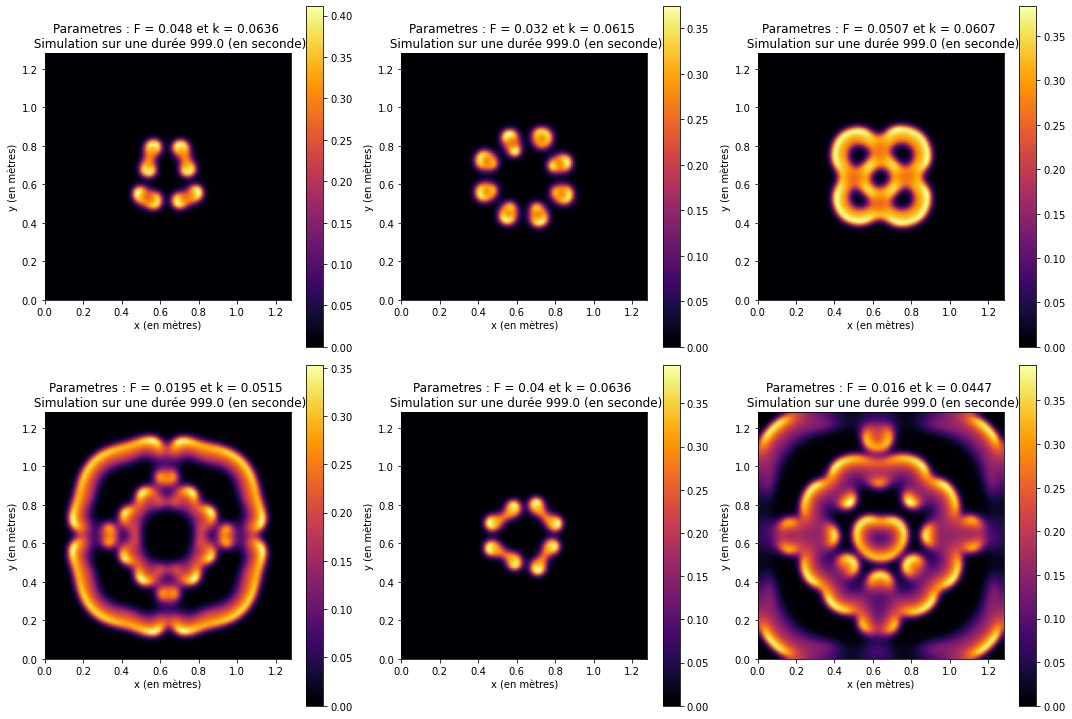

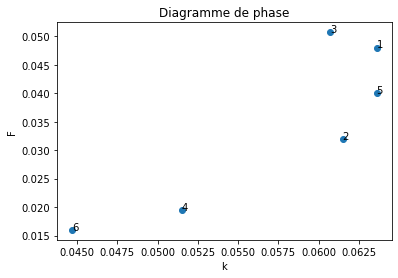

In [29]:
liste_F_k = [[0.048,0.0636], [0.032, 0.0615], [0.0507, 0.0607], [0.0195,0.0515], [0.04,0.0636],[0.016,0.0447]]
    
if diag_ok == 1:
        
    L = len(liste_F_k)
        
    liste_conc_G = []
    num = 1
    l = int((len(liste_F_k))**0.5+1)

    for couple in liste_F_k:
        Fr = couple[0]
        kr = couple[1]
        conc_S = np.ones((Nx, Ny))
        conc_G = np.zeros((Nx, Ny))
        conc_S[Nx//2 - d: Nx //2 + d, Ny//2 - d: Ny //2 + d] = 0.50
        conc_G[Nx//2 - d: Nx //2 + d, Ny//2 - d: Ny //2 + d] = 0.25 + np.random.normal(loc, scale, size=(2*d, 2*d)) # perturbation gaussienne
        for n in range(0,Npas):
            conc_S += G_S(conc_S,conc_G, Fr, kr, Ds, Dg, dx, dy)[0] * dt
            conc_G += G_S(conc_S,conc_G, Fr, kr, Ds, Dg, dx, dy)[1] * dt
        liste_conc_G.append(conc_G)

    plt.figure(1, (l*5, l*5))
    for conc_G in liste_conc_G:
        F_test = liste_F_k[num-1][0]
        k_test = liste_F_k[num-1][1]
        plt.subplot(l*110+num)
        M = np.max(conc_G)
        plt.pcolormesh(xx,yy,conc_G,shading='gouraud',cmap='inferno',vmin=0,vmax=M)
        plt.colorbar()
        plt.title("Parametres : F = " + str(F_test) + " et k = " + str(k_test)+ " \n Simulation sur une durée " + str(n*dt)[:5] + ' (en seconde)')
        plt.xlabel('x (en mètres)')
        plt.ylabel('y (en mètres)')
        num +=1
        plt.axis('square')
        plt.tight_layout()
    if diag_save_ok == 1:
        plt.savefig(nom_dossier_diag + '/diagramme_' + date_heure + '.jpg', dpi = 400)
    #lignes permettant d'afficher les valeurs prises par k et F, numérotées dans le même ordre que les images
    F_tab, k_tab = np.array(liste_F_k)[:,0], np.array(liste_F_k)[:,1]
    n = [i for i in range(1, L+1)]
    fig, ax = plt.subplots()
    ax.scatter(k_tab,F_tab)
    for i, txt in enumerate(n):
        ax.annotate(txt, (k_tab[i],F_tab[i]))
    plt.ylabel('F')
    plt.xlabel('k')
    plt.title('Diagramme de phase')
    plt.savefig(nom_dossier_diag + '/graphe_diagramme.jpg', )
    plt.show()

Texte qui parle du diagramme de phase

## Taille caractéristiques et analyse de Fourrier

In [30]:
plt.pcolormesh(xx,yy,np.log(np.fft.fftshift(np.abs(np.fft.fft2(conc_G())))),shading='gouraud',cmap='inferno',vmin=0,vmax=M)

TypeError: 'numpy.ndarray' object is not callable

## Conclusion

-On a appris quoi
-Modèle qui fait des jolies choses , lien avec les motifs de Turing ?
-Code très flexible, on espere qu'il est tel qu'il serait utilisé par des physiciens